In [1]:
import os

import numpy as np
import pandas as pd

import bofire.strategies.api as strategies
import bofire.surrogates.api as surrogates
from bofire.benchmarks.api import Ackley, Branin
from bofire.data_models.acquisition_functions.api import qLogEI
from bofire.data_models.domain.api import Domain, Inputs, Outputs
from bofire.data_models.features.api import (
    ContinuousInput,
    ContinuousOutput,
    TaskInput,
)
from bofire.data_models.objectives.api import MaximizeObjective
from bofire.data_models.strategies.api import SoboStrategy
from bofire.data_models.surrogates.api import (
    BotorchSurrogates,
    MultiTaskGPSurrogate,
    SingleTaskGPSurrogate,
)

/var/folders/6j/glsx_1g54671hs1jf1v0k06h0000gn/T/ipykernel_1472/2994205888.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/josepablofolch/miniconda3/envs/bofire_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/josepablofolch/Documents/Imperial College/Coding Projects/bofire/bofire/strategies/predictives/enting.py:14: UserWarning: entmoot not installed, BoFire's `EntingStrategy` cannot be used.
 

In [2]:
import matplotlib.pyplot as plt

In this notebook we show how to use BoFire for the purposes of transfer learning Bayesian optimization. In particular, we assume we have a task $f_2$ with data that is relevant to the optimization of our current task $f_1$. The procedure is simple, we fit a MultiTask GP to both data-sets, however only carry out the BO on $f_1$, i.e., we optimize the acquisition functions on on the task $f_1$.

We build a small data-set using the target task:

$$ f_1(x) = \sin(2 \pi x) $$

And we will have data the second related task:

$$ f_2 = 0.9 \sin(2 \pi x) + 0.2 \cos(3 \pi x) - 0.2 $$

We begin by defining the functions, generating some data, and plotting it. We generate 15 data-points for Task 2 and just 4 data-points for Task 1, all the data-points in Task 1 will be in a restricted area of the space.

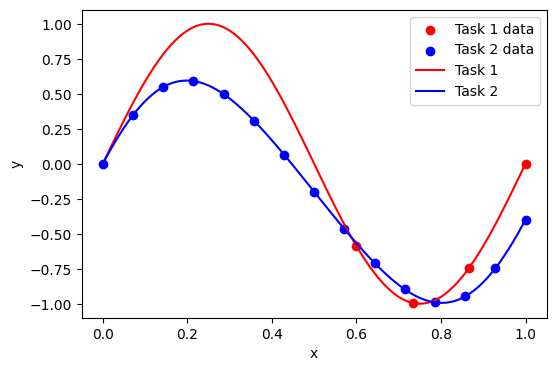

In [3]:
def task_1_f(x):
    return np.sin(x * 2 * np.pi)

def task_2_f(x):
    return 0.9* np.sin(x * 2 * np.pi) - 0.2 + 0.2 * np.cos(x * 3 * np.pi)

x = np.linspace(0, 1, 101)

# generate lots of low fidelity data and a few high fidelity data

task_1_x = np.linspace(0.6, 1, 4)
task_1_y = task_1_f(task_1_x)

task_2_x = np.linspace(0, 1, 15)
task_2_y = task_2_f(task_2_x)

# set the data in the pandas format
experiments = pd.DataFrame({"x": np.concatenate([task_1_x, task_2_x]), "y": np.concatenate([task_1_y, task_2_y]), "task": ["task_1"]*len(task_1_x) + ["task_2"]*len(task_2_x)})

plt.figure(figsize=(6, 4))

plt.scatter(task_1_x, task_1_y, label="Task 1 data", color="red")
plt.scatter(task_2_x, task_2_y, label="Task 2 data", color="blue")

plt.plot(x, task_1_f(x), label="Task 1", color="red")
plt.plot(x, task_2_f(x), label="Task 2", color="blue")

plt.xlabel("x")
plt.ylabel("y")

plt.legend()

# Inference

At first we will show to do inference with the model and see make predictions using multiple data-sets.

We first set-up the model according to BoFire's API, by defining the set of input and output features and the corresponding bounds, and create a surrogate data model:

- To define the task we choose the `TaskInput` feature, everything else follows standard BoFire procedure.

In [4]:
# set-up the task model with allowed variable as ["True"] for the target task and ["False"] for the other task
task_input = TaskInput(key = "task", categories=["task_1", "task_2"])
# define the input features
input_features = [ContinuousInput(key = "x", bounds = (0, 1)), task_input]

objective = MaximizeObjective(w = 1)
output_features = [ContinuousOutput(key = "y", objective = objective)]

inputs = Inputs(features = input_features)
outputs = Outputs(features = output_features)

surrogate_data = MultiTaskGPSurrogate(inputs = inputs, outputs = outputs)

We map from the surrogate data into the surrogate model and fit the data.

In [5]:
surrogate = surrogates.map(surrogate_data)

surrogate.fit(experiments)

/Users/josepablofolch/miniconda3/envs/bofire_env/lib/python3.12/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708328286453/work/torch/csrc/utils/tensor_new.cpp:623.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


Plot to see how we are able to predict outside of the region where there is data for Task 1, since we can use the data from Task 2 and the learnt correlations:

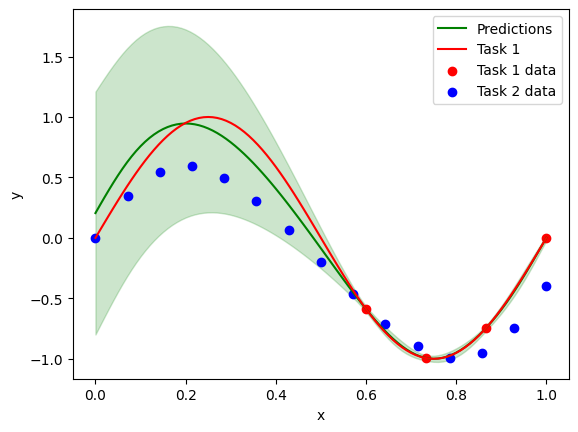

In [6]:
# predict the high fidelity data
x_predict = np.linspace(0, 1, 101)
y_predict = surrogate.predict(pd.DataFrame({"x": x_predict, "task": ["task_1"]*len(x_predict)}))

# plot data and predictions
plt.plot(x_predict, y_predict["y_pred"], label="Predictions", color="green")
plt.fill_between(x_predict, y_predict["y_pred"] - 2 * y_predict["y_sd"], y_predict["y_pred"] + 2 * y_predict["y_sd"], color="green", alpha=0.2)

# plot the high fidelity function
plt.plot(x, task_1_f(x), label="Task 1", color="red")

# plot the data too
plt.scatter(experiments[experiments["task"] == "task_1"]["x"], experiments[experiments["task"] == "task_1"]["y"], label="Task 1 data", color="red")
plt.scatter(experiments[experiments["task"] == "task_2"]["x"], experiments[experiments["task"] == "task_2"]["y"], label="Task 2 data", color="blue")

plt.xlabel("x")
plt.ylabel("y")

plt.legend()

# Transfer Learning Bayesian Optimisation

Let us now integrate this into BoFire's `SOBO` strategy. This can be done by following the standard BoFire syntax with a small modification.

- For `TaskInput` we must set the variable `allowed` as a list, with each element in the list corresponding to one of the `categories` such that all auxiliary tasks have `False` and target task has `True`. For example, we have `categories = ["task_1, task_2"]` and the goal of our optimization is to optimize `task_1` therefore we set `allowed = [True, False]`:



In [7]:
input_features = [ContinuousInput(key = "x", bounds = (0, 1)),
                TaskInput(key = "task",
                categories=["task_1", "task_2"],
                allowed=[True, False])]

objective = MaximizeObjective(w = 1)
output_features = [ContinuousOutput(key = "y", objective = objective)]

inputs = Inputs(features = input_features)
outputs = Outputs(features = output_features)

surrogate_data = MultiTaskGPSurrogate(inputs = inputs, outputs = outputs)
surrogate_specs = BotorchSurrogates(surrogates = [surrogate_data])

# define the acquisition function
acquisition = qLogEI()

sobo_strategy_data_model = SoboStrategy(
    domain = Domain(
        inputs = inputs,
        outputs = outputs,
    ),
    acquisition_function=acquisition,
    surrogate_specs=surrogate_specs,
)

sobo_strategy = strategies.map(sobo_strategy_data_model)

sobo_strategy.tell(experiments)

We can now generate experimental candidates:

In [8]:
candidates = sobo_strategy.ask(3)

candidates

,x,task,y_pred,y_sd,y_des
0,0.152676,task_1,0.905033,0.423189,0.905033
1,0.233283,task_1,0.927779,0.361715,0.927779
2,0.192379,task_1,0.944989,0.394752,0.944989


If we instead wanted to optimize `task_2` instead of `task_1`, we simply change `allowed = [False, True]`:

In [9]:
input_features = [ContinuousInput(key = "x", bounds = (0, 1)),
                TaskInput(key = "task",
                categories=["task_1", "task_2"],
                allowed = [False, True])]

objective = MaximizeObjective(w = 1)
output_features = [ContinuousOutput(key = "y", objective = objective)]

inputs = Inputs(features = input_features)
outputs = Outputs(features = output_features)

surrogate_data = MultiTaskGPSurrogate(inputs = inputs, outputs = outputs)
surrogate_specs = BotorchSurrogates(surrogates = [surrogate_data])

# define the acquisition function
acquisition = qLogEI()

sobo_strategy_data_model = SoboStrategy(
    domain = Domain(
        inputs = inputs,
        outputs = outputs,
    ),
    acquisition_function=acquisition,
    surrogate_specs=surrogate_specs,
)

sobo_strategy = strategies.map(sobo_strategy_data_model)

sobo_strategy.tell(experiments)

We  now obtain candidates for `task_2`:

In [10]:
candidate = sobo_strategy.ask(1)

candidate

,x,task,y_pred,y_sd,y_des
0,0.19792,task_2,0.593978,0.011442,0.593978


Let us now run a Bayesian optimization loop on the Branin benchmark to show the usefulness of transfer learning Bayesian optimization in a practical setting. We create a small data-set composed of the Branin benchmark itself, and a large one composed of the Branin function with a small amount of bias added by summing the Branin and Ackley functions.

We begin by defining a function that creates random initial data-sets, and create as many data-sets as the number of runs we want to average over:

In [11]:
benchmark = Branin()
bias = Ackley()

def create_data_set():
    # choose the initial data-sets
    low_fidelity_x = benchmark.domain.inputs.sample(25)
    high_fidelity_x = benchmark.domain.inputs.sample(4)

    # create the observations
    high_fidelity_data = benchmark.f(high_fidelity_x, return_complete = True)
    low_fidelity_bias = bias.f(low_fidelity_x, return_complete = True)

    low_fidelity_data = benchmark.f(low_fidelity_x, return_complete = True)
    low_fidelity_data['y'] = low_fidelity_data['y'] + 0.15 * low_fidelity_bias['y']

    # create a joint data-set, with the task variable
    high_fidelity_data['task'] = 'task_1'
    low_fidelity_data['task'] = 'task_2'

    experiments_joint = pd.concat([low_fidelity_data, high_fidelity_data])

    return high_fidelity_data, experiments_joint

In [12]:
single_task_all_regrets = []

SMOKE_TEST = os.environ.get("SMOKE_TEST")
if SMOKE_TEST:
    num_runs = 1
    verbose = False
else:
    num_runs = 10
    verbose = True

# create the initial data-sets for each run

high_fidelity_datasets = []
experiments_joint_datasets = []

for _ in range(num_runs):
    high_fidelity_data, experiments_joint = create_data_set()
    high_fidelity_datasets.append(high_fidelity_data)
    experiments_joint_datasets.append(experiments_joint)

Let us now run a Bayesian optimization loop only using the high-fidelity data:

In [ ]:
for run in range(num_runs):
    high_fidelity_data = high_fidelity_datasets[run]

    inputs = benchmark.domain.inputs
    outputs = benchmark.domain.outputs

    surrogate_data = SingleTaskGPSurrogate(inputs = inputs, outputs = outputs)
    surrogate_specs = BotorchSurrogates(surrogates = [surrogate_data])

    acquisition = qLogEI()

    sobo_strategy_data_model = SoboStrategy(
        domain = Domain(
            inputs = inputs,
            outputs = outputs,
        ),
        acquisition_function=acquisition,
        surrogate_specs=surrogate_specs,
    )

    sobo_strategy = strategies.map(sobo_strategy_data_model)

    dataset = high_fidelity_data.drop(columns = ['task'])

    sobo_strategy.tell(dataset)

    regrets_single_task = []

    init_regret = sobo_strategy.experiments['y'][sobo_strategy.experiments['y'].argmin()] - benchmark.get_optima()['y'][0].item()
    regrets_single_task.append(init_regret)

    for iter in range(10):
        candidate = sobo_strategy.ask(1)
        y = benchmark.f(candidate, return_complete = True)
        sobo_strategy.tell(y)

        regret = sobo_strategy.experiments['y'][sobo_strategy.experiments['y'].argmin()] - benchmark.get_optima()['y'][0].item()
        regrets_single_task.append(regret)

        print(f"Iteration {iter+1}")
        print(f"Regret: {regret}")

    single_task_all_regrets.append(regrets_single_task)

We now repeat the experiment but using transfer learning BO:

In [ ]:
multitask_all_regrets = []

for run in range(num_runs):
    experiments_joint = experiments_joint_datasets[run]

    input_features = benchmark.domain.inputs.features + [TaskInput(key = "task", categories = ["task_1", "task_2"], allowed = [True, False])]
    inputs = Inputs(features = input_features)
    outputs = benchmark.domain.outputs

    surrogate_data = MultiTaskGPSurrogate(inputs = inputs, outputs = outputs)
    surrogate_specs = BotorchSurrogates(surrogates = [surrogate_data])

    acquisition = qLogEI()

    sobo_strategy_data_model = SoboStrategy(
        domain = Domain(
            inputs = inputs,
            outputs = outputs,
        ),
        acquisition_function=acquisition,
        surrogate_specs=surrogate_specs,
    )

    sobo_strategy = strategies.map(sobo_strategy_data_model)

    dataset = experiments_joint.copy()

    sobo_strategy.tell(dataset)

    regrets_transfer_learning = []

    # obtain experiments at the highest fidelity
    experiments = sobo_strategy.experiments[sobo_strategy.experiments["task"] == "task_1"]['y']
    init_regret = experiments[experiments.argmin()] - benchmark.get_optima()['y'][0].item()
    regrets_transfer_learning.append(init_regret)

    for iter in range(10):
        candidate = sobo_strategy.ask(1)
        candidate = candidate.drop(columns = ['task'])
        y = benchmark.f(candidate, return_complete = True)
        y['task'] = 'task_1'
        sobo_strategy.tell(y)

        experiments = sobo_strategy.experiments[sobo_strategy.experiments["task"] == "task_1"]['y'].reset_index(drop=True)
        regret = experiments[experiments.argmin()] - benchmark.get_optima()['y'][0].item()
        regrets_transfer_learning.append(regret)

        print(f"Iteration {iter+1}")
        print(f"Regret: {regret}")

    multitask_all_regrets.append(regrets_transfer_learning)

We now plot the quantiles and median simple regret against iteration:

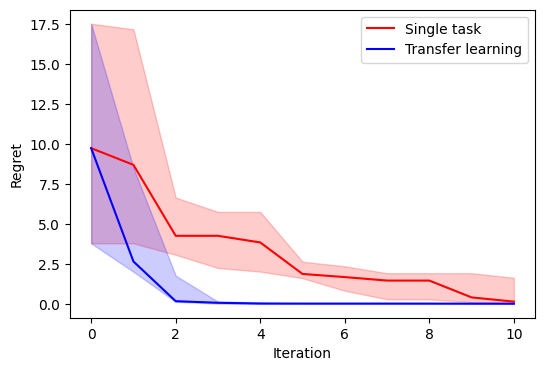

In [15]:
# plot the results
plt.figure(figsize=(6, 4))

regrets_single_task_mean = np.median(np.array(single_task_all_regrets), axis=0)
regrets_transfer_learning_mean = np.median(np.array(multitask_all_regrets), axis=0)

# get the 25 and 75 percentiles
regrets_single_task_upper_quantile = np.quantile(np.array(single_task_all_regrets), 0.75, axis=0)
regrets_single_task_lower_quantile = np.quantile(np.array(single_task_all_regrets), 0.25, axis=0)

regrets_transfer_learning_upper_quantile = np.quantile(np.array(multitask_all_regrets), 0.75, axis=0)
regrets_transfer_learning_lower_quantile = np.quantile(np.array(multitask_all_regrets), 0.25, axis=0)

plt.plot(regrets_single_task_mean, label="Single task", color="red")
plt.plot(regrets_transfer_learning_mean, label="Transfer learning", color="blue")

plt.fill_between(np.arange(11), regrets_single_task_upper_quantile, regrets_single_task_lower_quantile, color="red", alpha=0.2)
plt.fill_between(np.arange(11), regrets_transfer_learning_upper_quantile, regrets_transfer_learning_lower_quantile, color="blue", alpha=0.2)

plt.xlabel("Iteration")
plt.ylabel("Regret")

plt.legend()

plt.show()

We can see that using transfer learning leads to significant improvement.